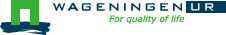



# Parametrize WOFOST 8.1 SNOMIN with SoilGrids

The aim of this notebook is to demonstrate how WOFOST 8.1 with SNOMIN can be parametrized with the global soil map SoilGrids (https://www.isric.org/explore/soilgrids). We will follow the steps below:
1. Download relevant soil texture and soil chemistry data from SoilGrids for a specific longitude and latitude.
2. Use Wösten pedotransfer function to convert SoilGrids data into Van Genuchten parameters
3. Convert Van Genuchten parameters into input values for WOFOST 8.1 with SNOMIN.
4. Run an example simulation for winter wheat.

**Important notice**
This demonstrates how to use input from SoilGrids for running WOFOST 8.1/SNOMIN. However, input from gridded soil maps is notiously uncertain because of limited soil information in many parts of the world. Results from WOFOST8.1/SNOMIN based on input from SoilGrids should be carefully evaluated. Preferably by taking uncertainty from SoilGrids into account. 


Herman Berghuijs and Allard de Wit, January 2025

### Prerequisites for running this notebook
1. PCSE and its dependencies. See the  [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) guide for more information
2. pandas for processing and storing WOFOST output
3. matplotlib for generating charts

## 1. Import relevant modules
First, import the required modules:

In [1]:
%matplotlib inline
import sys
from pathlib import Path

from IPython.display import Code
import yaml
import pandas as pd
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

from pcse.models import Wofost81_NWLP_MLWB_SNOMIN
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

## 2. Download soil properties from SoilGrids

[SoilGrids](https://www.isric.org/explore/soilgrids) is a system for global digital soil mapping. It predicts soil properties by training machine learning models to a large (more than 230000) number of soil profile observations across the globe. In this PCSE Notebook, we will collect the following soil properties from SoilGrids:

|Symbol in SoilGrids|Meaning|Unit|
|---|---|---|
|bdod|Bulk density|$\rm g$ soil $\rm cm^{-3}$ soil|
|clay|Clay percentage|$\rm cg$ soil $\rm g^{-1}$ soil|
|pph2o|Soil pH|-|
|sand|Sand percentage|$\rm cg$ sand $\rm g^{-1}$ soil|
|silt|Silt percentage|$\rm cg$ silt $\rm g^{-1}$ soil|
|soc|Soil organic carbon permillage|$\rm g$ C $\rm kg^{-1} soil$|
|nitrogen|Total nitrogen content|$\rm g$ N $\rm kg^{-1} soil$|

SoilGrids provides each of these variables for different soil layers. It distiguishes soil layers between 0-5 cm depth, 5-15 cm depth, 15-30 cm depth, 30-60 cm depth, 60-100 cm, and 100-200 cm depth. For each of the variables at each depth, we will request to SoilGrids to provide the values for a specific location defined by its latitude and longtitude. The required input variables for such a request are:

In [2]:
# Define location
lat = 52.651
lon = 5.737

# Define variables that need to be collected for this location
variables = ["bdod", "clay", "phh2o", "sand", "silt", "soc", "nitrogen"]

# Define minimum and maximum depths for each SoilGrids soil layer
zmins = [0, 5, 15, 30, 60]
zmaxs = [5, 15, 30, 60, 100]

# Define the request URL
request_url = "https://rest.isric.org/soilgrids/v2.0/properties/query"

SoilGrids requires that the depth of each soil layer in a request is provided in a specific string format, i.e. <zmin>-<zmax>cm. We will therefore use the zmin and zmax lists to build an array that contains the depths

In [3]:
depth_name_template = '{zmin}-{zmax}cm'
depths = []
for zmin, zmax in zip(zmins, zmaxs):
    depth = depth_name_template.format(zmin=zmin, zmax = zmax)
    depths.append(depth)

print(f"depths = {depths}")

depths = ['0-5cm', '5-15cm', '15-30cm', '30-60cm', '60-100cm']


Now the request is and the obtained data are stored in a dictionary: 

In [4]:
import requests
p1 = {"lat": lat, "lon": lon}
props = {"property": variables, "depth": depths}
res = requests.get(request_url, params = {**p1, **props})
resultd = res.json()

The structure of the result dictionary looks like:

In [5]:
import json
print(json.dumps(resultd, sort_keys = False, indent=6))

{
      "type": "Feature",
      "geometry": {
            "type": "Point",
            "coordinates": [
                  5.737,
                  52.651
            ]
      },
      "properties": {
            "layers": [
                  {
                        "name": "bdod",
                        "unit_measure": {
                              "d_factor": 100,
                              "mapped_units": "cg/cm\u00b3",
                              "target_units": "kg/dm\u00b3",
                              "uncertainty_unit": ""
                        },
                        "depths": [
                              {
                                    "range": {
                                          "top_depth": 0,
                                          "bottom_depth": 5,
                                          "unit_depth": "cm"
                                    },
                                    "label": "0-5cm",
                                    "

For each location in the dictionary, properties are stored. These properties consists of layers that contain data for the different variables (so the "layers" key does not represent different soil layers here!). Each variable has a name ('name'), it contains information about the units in which the variable is expressed ('unit_measure'). The depth attribute ('depths') contains information on the values that were measured between two particular depths (between 'top_depth' and 'bottom_depth'). The mean value of any variable can be obtained by the following Python statement:

```python
mean_value = resultd["properties"]["layers"][index of variable]["depths"][index of soil layer]["values"]["mean"]`
```
For instance, the bulk density (index of variable = 0) of between 15 and 30 cm depth (index of soil layer = 2) can be obtained as

In [6]:
RHOD_15_to_30cm_raw = resultd['properties']["layers"][0]["depths"][2]["values"]["mean"]
print(RHOD_15_to_30cm_raw)

116


Note that SoilGrids stores variables as integers instead of floats. Therefore, the raw values are not always expressed in the target units. For instance, the raw value of the bulk density printed above is expressed in $\rm dag$ $\rm dm^{-3}$ instead of in the target unit $\rm kg$ $\rm dm^{-3}$ (equivalent to $\rm g$ $\rm cm^{-3}$). The d_factor attribute contains a division factor to convert a unit in which a variable is stored to the target unit. The d_factor of any variable can be obtained by the following statement:

```python
d_factor = resultd["properties"]["layers"][i]["unit_measure"]["d_factor"]</p>
```
 We will use the d-factor for the bulk density to convert the unit to its target unit

In [7]:
d_factor_RHOD = resultd["properties"]["layers"][0]["unit_measure"]["d_factor"]
RHOD_15_to_30cm = RHOD_15_to_30cm_raw / d_factor_RHOD 

print(f"The raw mean value of the bulk density between 15 and 30 cm is stored as {RHOD_15_to_30cm_raw}")
print(f"The bulk density, expressed in the target unit, is {RHOD_15_to_30cm} g cm-3")

The raw mean value of the bulk density between 15 and 30 cm is stored as 116
The bulk density, expressed in the target unit, is 1.16 g cm-3


We can now make a data frame that contains the soil properties per depth, expressed in the target units

In [8]:
soild = {}
soild["latitude"] = []
soild["longitude"] = []       
soild["zmin"] = []
soild["zmax"] = []
for i in range(0, len(depths)):
    soild["zmin"].append(zmins[i])
    soild["zmax"].append(zmaxs[i]) 
    soild["latitude"].append(lat)
    soild["longitude"].append(lon)
for i, var in enumerate(variables):
    var_name = resultd['properties']["layers"][i]['name']
    if(var_name in variables):
        soild[var_name] = []
        for j in range(0, len(depths)):
            raw_value = resultd['properties']["layers"][i]["depths"][j]["values"]["mean"]
            d_factor = resultd["properties"]["layers"][i]["unit_measure"]["d_factor"]
            value = raw_value / d_factor
            soild[var_name].append(value)

df_soilgrids = pd.DataFrame.from_dict(soild) 
df_soilgrids

,latitude,longitude,zmin,zmax,bdod,clay,nitrogen,phh2o,sand,silt,soc
0,52.651,5.737,0,5,0.97,26.7,5.58,6.7,24.9,48.4,99.8
1,52.651,5.737,5,15,1.09,26.1,2.97,6.9,24.8,49.1,34.0
2,52.651,5.737,15,30,1.16,26.4,5.26,6.8,24.1,49.5,71.5
3,52.651,5.737,30,60,1.06,28.7,6.02,6.8,21.9,49.4,102.2
4,52.651,5.737,60,100,1.16,26.8,5.68,6.8,23.3,49.9,107.6


## 3 Use Wösten pedotransfer functions to convert SoilGrids data into Van Genuchten parameters

The soil parameters SMfromPF and CONDfromPF for WOFOST 8.1 and SNOMIN are table functions that describe the relationship between pF (10-base log of suction pressure) and the soil moisture content and the 10-base log of the hydraulic conductivity. These table functions are determined per soil layer and can be constructed with Van Genuchten parameters (Van Genuchten, 1980). Van Genuchten parameters can be directly determined by fitting the Van Genuchten water retention model to data of soil suction measurements at different pFs. However, these data are often not available. Pedotransfer functions are functions that convert soil textural data, that are easier to obtain than water retention curve measurements, into Van Genuchten parameters. In this section, we will demonstrate how the Wösten pedotransfer functions can be applied to obtain Van Genuchten parameters:

In [9]:
from PedotransferFunctions import PedotransferFunctionsWosten

The Wösten pedotransfer functions calculate the Van Genuchten parameters $\alpha$, $\lambda$, $K_{\rm sat}$ $n$, and $\theta_{\rm s}$ (soil moisture content at saturation) for each soil layer from soil textural properties. The functions require the following input:

|Symbol|Meaning|Unit|
|---|---|---|
|D|Bulk density|$\rm g$ soil $\rm cm^{-3}$ soil|
|C|Clay percentage|$\rm cg$ soil $\rm g^{-1}$ soil|
|OM|Organic matter percentage|$\rm cg$ soil $\rm g^{-1}$ soil|
|theta_r|Residual soil moisture content|$\rm cg$ soil $\rm g^{-1}$ soil|
|S|Silt percentage|$\rm cg$ silt $\rm g^{-1}$ soil|
|OM|Soil organic carbon permillage|$\rm g$ C $\rm kg^{-1} soil$|

Furthermore, for each soil layer it has to be specified whether or not it is defined as top soil (True) or not (False). This is indicated with the boolean variable is_topsoil. We are now ready to calculate the Van Genuchten parameters per soil layer.

The bulk density and the percentages of clay and silt can be directly adopted from the values requested from SoilGrids:

In [10]:
ptfw = PedotransferFunctionsWosten()
df_vgp = df_soilgrids.copy()[["latitude", "longitude", "zmin", "zmax", "soc", "phh2o", "nitrogen"]]
df_vgp["C"] = df_soilgrids.clay.copy()
df_vgp["D"] = df_soilgrids.bdod.copy()
df_vgp["S"] = df_soilgrids.silt.copy()

SoilGrids does not provide values for the soil organic matter percentage. Assuming that organic matter consists for 58% of carbon, we can calculate the soil organic matter percentage from the soil organic carbon permillage from SoilGrids.

In [11]:
f_C_to_OM = 0.58
pml_to_pct = 0.1
df_vgp["OM"] = df_soilgrids.soc.copy() * pml_to_pct * f_C_to_OM

For the residual soil moisture content, we assume a low value (0.01).

In [12]:
df_vgp["theta_r"] = 0.01

We assume that the entire rootable soil qualifies as top soil and we set the lower boundary of the top soil equal to 100 m.

In [13]:
lower_boundary_top_soil = 100.

def calculate_isTopsoil(zmin, zmax, zmax_topsoil):
    if (zmin <= zmax_topsoil) & (zmax <= zmax_topsoil):
        isTopsoil = True
    else:
        isTopsoil = False
    return isTopsoil

df_vgp["is_topsoil"] = df_vgp.apply(lambda x: calculate_isTopsoil(x.zmin, x.zmax, lower_boundary_top_soil), axis = 1)

The Van Genuchten parameters can now be calculated

In [14]:
df_vgp["alpha"] = df_vgp.apply(lambda x: ptfw.calculate_alpha(x.C, x.D, x.S, x.OM, x.is_topsoil), axis = 1)
df_vgp["k_sat"] = df_vgp.apply(lambda x: ptfw.calculate_k_sat(x.C, x.D, x.S, x.OM, x.is_topsoil), axis = 1)        
df_vgp["labda"] = df_vgp.apply(lambda x: ptfw.calculate_lambda(x.C, x.D, x.S, x.OM, x.is_topsoil), axis = 1)    
df_vgp["n"] = df_vgp.apply(lambda x: ptfw.calculate_n(x.C, x.D, x.S, x.OM, x.is_topsoil), axis = 1)
df_vgp["theta_s"] = df_vgp.apply(lambda x: ptfw.calculate_theta_s(x.C, x.D, x.S, x.OM, x.is_topsoil), axis = 1)
df_vgp

,latitude,longitude,zmin,zmax,soc,phh2o,nitrogen,C,D,S,OM,theta_r,is_topsoil,alpha,k_sat,labda,n,theta_s
0,52.651,5.737,0,5,99.8,6.7,5.58,26.7,0.97,48.4,5.7884,0.01,True,0.034011,43.306084,-2.421078,1.151591,0.565193
1,52.651,5.737,5,15,34.0,6.9,2.97,26.1,1.09,49.1,1.9720,0.01,True,0.024788,55.481231,-2.314732,1.199983,0.536291
2,52.651,5.737,15,30,71.5,6.8,5.26,26.4,1.16,49.5,4.1470,0.01,True,0.033184,29.734732,-2.845243,1.153889,0.508393
3,52.651,5.737,30,60,102.2,6.8,6.02,28.7,1.06,49.4,5.9276,0.01,True,0.036125,29.384103,-2.659989,1.134775,0.537240
4,52.651,5.737,60,100,107.6,6.8,5.68,26.8,1.16,49.9,6.2408,0.01,True,0.035723,19.493235,-2.858081,1.130981,0.503437


## 3 Generate soil input for WOFOST 8.1 with SNOMIN

All soil information is now available to generate soil input values for WOFOST 8.1 with SNOMIN. Rather than the minimum and maximum depths of the soil layers, WOFOST 8.1 with SNOMIN requires the thicknesses of the individual soil layers as input. Furthermore, SNOMIN requires values for the following values as input for each layer:

|Symbol WOFOST81 with SNOMIN|Variable|Unit|
|---|---|---|
|CRAIRC|Air content below which oxygen stress can occur|$\rm m^{3}$ air $\rm m^{-3}$ soil|
|RHOD|Bulk density|$\rm g$ soil $\rm cm^{-3}$ soil|
|CNRatioSOMI|C:N ratio organic matter|$\rm kg$ C $\rm kg^{-1}$ N|
|fSOMI|Initial soil organic matter fraction|$\rm kg$ OM $\rm kg^{-1}$ soil|
|PFFieldCapacity|pF value at which the soil layer is at field capacity|$\rm -$|
|PFWiltingPoint|pF value at which the soil layer is at permanent wilting point|$\rm -$|
|Soil_pH|Soil pH|$\rm -$|
|Thickness|Soil layer thickness|$\rm cm$|
|SMfromPF|Soil moisture content as a table function of pF|$\rm -$, $\rm m^{3}$ water $\rm m^{-3}$ soil|
|SurfaceConductivity|Surface conductivity|$\rm cm$ $\rm d^{-1}$|
|CONDfromPF|10-base log of hydraulic conductivity as a table function of pF|$\rm -$, $\rm ^{10}log(cm$ water $\rm d^{-1}$)|

Various of these variables can be directly adopted or calculated from the data collected from SoilGrids

In [15]:
pct_to_frac = 0.01

df_model_input = pd.DataFrame()
df_model_input["Thickness"] = df_vgp.zmax.copy() - df_vgp.zmin.copy()
df_model_input["RHOD"] = df_vgp.D.copy()
df_model_input["Soil_pH"] = df_vgp.phh2o.copy()
df_model_input["FSOMI"] = df_vgp.OM.copy() * pct_to_frac
df_model_input["CNRatioSOMI"] = df_vgp.soc.copy() / df_vgp.nitrogen.copy()

For the critical air content, we assumed the following value

In [16]:
df_model_input["CRAIRC"] = 0.03

The table functions SMfromPF and CONDfromPF  have to be determined for a range of pH values. First, we will define the range of pF values for which SMfromPF and CONDfromPF will be calculated.

In [17]:
pFs = [-1.0, 1.0, 1.3, 1.7, 2.0, 2.3, 2.4, 2.7, 3.0, 3.3, 3.7, 4.0, 4.2, 6.0]

The table functions can now be constructed:

In [18]:
from vangenuchten import calculate_soil_moisture_content, calculate_log10_hydraulic_conductivity

CONDfromPF_perlayer = []
SMfromPF_perlayer = []

for i in range(len(df_vgp)):
    CONDfromPF = []
    SMfromPF = []
    for j, pF in enumerate(pFs):
        r = calculate_soil_moisture_content(pF, df_vgp.alpha.iloc[i], df_vgp.n.iloc[i], df_vgp.theta_r.iloc[i], df_vgp.theta_s.iloc[i])
        SMfromPF.extend([pF, float(r)])
        r = calculate_log10_hydraulic_conductivity(pF, df_vgp.alpha.iloc[i], df_vgp.labda.iloc[i], df_vgp.k_sat.iloc[i], df_vgp.n.iloc[i])
        CONDfromPF.extend([pF, float(r)])
    CONDfromPF_perlayer.append(CONDfromPF)
    SMfromPF_perlayer.append(SMfromPF)

In [19]:
df_model_input["CONDfromPF"] = CONDfromPF_perlayer
df_model_input["SMfromPF"] = SMfromPF_perlayer
df_model_input

,Thickness,RHOD,Soil_pH,FSOMI,CNRatioSOMI,CRAIRC,CONDfromPF,SMfromPF
0,5,0.97,6.7,0.057884,17.885305,0.03,"[-1.0, 1.1599869631203001, 1.0, 0.175994160886...","[-1.0, 0.5650876800762732, 1.0, 0.546955741316..."
1,10,1.09,6.9,0.019720,11.447811,0.03,"[-1.0, 1.432988905911898, 1.0, 0.6187025260558...","[-1.0, 0.5362257603666135, 1.0, 0.521428925861..."
2,15,1.16,6.8,0.041470,13.593156,0.03,"[-1.0, 1.0072789736792898, 1.0, 0.041045097757...","[-1.0, 0.5083014032617711, 1.0, 0.492250373267..."
3,30,1.06,6.8,0.059276,16.976744,0.03,"[-1.0, 0.9192541755663745, 1.0, -0.10741101544...","[-1.0, 0.5371343084101181, 1.0, 0.520372069934..."
4,40,1.16,6.8,0.062408,18.943662,0.03,"[-1.0, 0.7255263790830794, 1.0, -0.30053780326...","[-1.0, 0.5033394095239623, 1.0, 0.488152921786..."


A number of input variables are defined on the level of the whole soil profile, instead of per soil layer. These are:

In [20]:
PFFieldCapacity = 2.0
PFWiltingPoint = 4.2
SurfaceConductivity = 70

Now, all information is available and can be converted into a structure that is compatible with WOFOST 8.1 with SNOMIN:

In [21]:
from vangenuchten import make_string_table
nlayers = len(df_model_input)
Thickness = df_model_input.Thickness.to_list()
CNRatioSOMI  = df_model_input.CNRatioSOMI.to_list()
CRAIRC  = df_model_input.CRAIRC.to_list()
FSOMI = df_model_input.FSOMI.to_list()   
RHOD = df_model_input.RHOD.to_list()
Soil_pH  = df_model_input.Soil_pH.to_list()

# below we generate the header of the soil input file as YAML input structure
soil_input_yaml = f"""
RDMSOL: {sum(Thickness)}
SoilProfileDescription:
    PFWiltingPoint: {PFWiltingPoint}
    PFFieldCapacity: {PFFieldCapacity}
    SurfaceConductivity: {SurfaceConductivity}
    GroundWater: false
    SoilLayers:
"""

# Here we generate the properties for each soil layer including layer thickness, hydraulic properties, 
# organic matter content, etc.
for i in range(nlayers):
    s = f"""    - Thickness: {Thickness[i]}
      CNRatioSOMI: {CNRatioSOMI[i]}
      CRAIRC: {CRAIRC[i]}
      FSOMI: {FSOMI[i]}
      RHOD: {RHOD[i]}
      Soil_pH: {Soil_pH[i]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[i])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i])}
"""
    soil_input_yaml += s

# A SubSoilType needs to be defined. In this case we make the subsoil equal to the properties
# of the deepest soil layer.
soil_input_yaml += \
f"""    SubSoilType:
      CNRatioSOMI: {CNRatioSOMI[-1]}
      CRAIRC: {CRAIRC[-1]}
      FSOMI: {FSOMI[-1]}
      RHOD: {RHOD[-1]}
      Soil_pH: {Soil_pH[-1]}
      Thickness: {Thickness[-1]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[-1])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i-1])}
"""

soil_dict = yaml.safe_load(soil_input_yaml)
Code(json.dumps(soil_dict,indent=6), language = "Python")

{
      "RDMSOL": 100,
      "SoilProfileDescription": {
            "PFWiltingPoint": 4.2,
            "PFFieldCapacity": 2.0,
            "SurfaceConductivity": 70,
            "GroundWater": false,
            "SoilLayers": [
                  {
                        "Thickness": 5,
                        "CNRatioSOMI": 17.885304659498207,
                        "CRAIRC": 0.03,
                        "FSOMI": 0.057884000000000005,
                        "RHOD": 0.97,
                        "Soil_pH": 6.7,
                        "SMfromPF": [
                              -1.0,
                              0.5651,
                              1.0,
                              0.547,
                              1.3,
                              0.5302,
                              1.7,
                              0.4937,
                              2.0,
                              0.4581,
                              2.3,
                              0.4196,
                              2.4,
                              0.4068,
                              2.7,
                              0.3694,
                              3.0,
                              0.3346,
                              3.3,
                              0.3026,
                              3.7,
                              0.2647,
                              4.0,
                              0.2394,
                              4.2,
                              0.224,
                              6.0,
                              0.1242
                        ],
                        "CONDfromPF": [
                              -1.0,
                              1.16,
                              1.0,
                              0.176,
                              1.3,
                              -0.1622,
                              1.7,
                              -0.7325,
                              2.0,
                              -1.2329,
                              2.3,
                              -1.7722,
                              2.4,
                              -1.9574,
                              2.7,
                              -2.5226,
                              3.0,
                              -3.0962,
                              3.3,
                              -3.6738,
                              3.7,
                              -4.4465,
                              4.0,
                              -5.0268,
                              4.2,
                              -5.4138,
                              6.0,
                              -8.8987
                        ]
                  },
                  {
                        "Thickness": 10,
                        "CNRatioSOMI": 11.447811447811446,
                        "CRAIRC": 0.03,
                        "FSOMI": 0.01972,
                        "RHOD": 1.09,
                        "Soil_pH": 6.9,
                        "SMfromPF": [
                              -1.0,
                              0.5362,
                              1.0,
                              0.5214,
                              1.3,
                              0.5059,
                              1.7,
                              0.4682,
                              2.0,
                              0.4282,
                              2.3,
                              0.3837,
                              2.4,
                              0.3687,
                              2.7,
                              0.3255,
                              3.0,
                              0.286,
                              3.3,
                              0.2508,
                              3.7,
                              0.2105,
                              4.0,
                              0.1847,
                              4.2,
                              0.1694,
         

## 4 Generate site input for WOFOST 8.1 with SNOMIN

The site model input variables are obtained by the PCSE SiteDataProvider. For most input variables, the default values are assumed and do not have to be specified. However, the following variables are obligatory and must be provided by the user

|Symbol WOFOST81 with SNOMIN|Variable|Unit|
|---|---|---|
|CO2|$\rm CO_{2}$ concentration in atmosphere|ppm|
|NH4I|$\rm {NH_{4}}^{+}$$\rm-N$ amount per soil layer|kg $\rm {NH_{4}}^{+}$$\rm-N$ $\rm ha^{-1}$|
|NO3I|$\rm {NO_{3}}^{-}$$\rm-N$ amount per soil layer|kg $\rm {NO3_{4}}^{+}$$\rm-N$ $\rm ha^{-1}$|
|WAV|Initial amount of available water in soil profile|cm water|

For CO2, we assume a value of 400 ppm.

In [22]:
CO2 = 400

Under the assumption that the soil moisture content is at field capacity at the start of the simulation, WAV can be calculated as

In [23]:
pf_fc = float(soil_dict["SoilProfileDescription"]["PFFieldCapacity"])
pf_wp = float(soil_dict["SoilProfileDescription"]["PFWiltingPoint"])
soil_layers = soil_dict["SoilProfileDescription"]["SoilLayers"]

In [24]:
from libfunc import afgen
WAV = 0.
for i in range(0, len(soil_layers)):
    thickness_layer = soil_layers[i]["Thickness"]
    SMfromPF = soil_layers[i]["SMfromPF"]
    theta_fc = afgen(pf_fc, SMfromPF)
    theta_wp = afgen(pf_wp, SMfromPF)
    WAV_layer = (theta_fc - theta_wp) * thickness_layer
    WAV += WAV_layer

The parameters `NO3I` and `NH4I` are lists that contain inorganic amounts of N in the form of respectively $\rm {NH_{4}}^{+}$$\rm-N$ and $\rm {NO_{3}}^{-}$$\rm-N$ per soil layer. The length of these lists should thus be the same as the number of soil layers. In this example, we assume that there is 15 kg $\rm {NO_{3}}^{-}$$\rm-N$ $\rm ha^{-1}$ in the upper soil layer (0 - 5 cm), 10 kg $\rm {NO_{3}}^{-}$$\rm-N$ $\rm ha^{-1}$ in the second soil layer (5 - 15 cm), 5 kg $\rm {NO_{3}}^{-}$$\rm-N$ $\rm ha^{-1}$ in the third soil layer (15 - 30 cm), and for the rest there is no inorganic N in any layer.

In [25]:
NH4I = [0] * len(soil_layers)
NO3I = [0] * len(soil_layers)
NO3I[0] = 15.
NO3I[1] = 10.
NO3I[2] = 5.

We have now collected all obligatory input for the PCSE SiteDataProvider and can now obtain a dictionary with site input values:

In [26]:
from pcse.input import WOFOST81SiteDataProvider_SNOMIN
site_dict = WOFOST81SiteDataProvider_SNOMIN(WAV = WAV, 
                                            CO2 = CO2,
                                            NH4I = NH4I,
                                            NO3I = NO3I,                                                
                                            )

In [27]:
print(site_dict)

{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 20.8925, 'SMLIM': 0.4, 'CO2': 400.0, 'A0SOM': 24.0, 'CNRatioBio': 9.0, 'FASDIS': 0.5, 'KDENIT_REF': 0.06, 'KNIT_REF': 1.0, 'KSORP': 0.0005, 'MRCDIS': 0.001, 'NH4ConcR': 0.0, 'NO3ConcR': 0.0, 'NH4I': [0, 0, 0, 0, 0], 'NO3I': [15.0, 10.0, 5.0, 0, 0], 'WFPS_CRIT': 0.8}


## 5 Obtain AgroManagement, crop, and weather input for WOFOST 8.1 with SNOMIN

The AgroManagement data and weather data are loaded from example files:

In [28]:
from pcse.input import YAMLAgroManagementReader
cwd = Path.cwd()
input_dir = cwd / "data"
agro_fp = input_dir / "agro" / "wheat_wageningen_agro.yaml"
agro_dict = YAMLAgroManagementReader(agro_fp)   

from pcse.input import ExcelWeatherDataProvider
weather_fp = input_dir / "meteo" / "weather_wageningen.xlsx"
wdp = ExcelWeatherDataProvider(weather_fp)

The crop data are obtained using the PCSE CropDataProvider

In [29]:
from pcse.input import YAMLCropDataProvider
p = YAMLCropDataProvider(Wofost81_NWLP_MLWB_SNOMIN)
p.set_active_crop(crop_name = "wheat", variety_name = "Julius")

Before we can start the simulation, it is important to realize that the soil water module in WOFOST 8.1 with SNOMIN requires that the maximum rooting depth of the crop coincides with the a boundary between two soil layers in the profile. The maximum rooting depth of the crop is:

In [30]:
RDMCR = p["RDMCR"]
RDMCR

125.0

A RDMCR of 125 cm is lower than the lower boundary of the bottom soil layer. We solved this issue by increasing the thickness of the lowest soil layer in such a way that the boundary between the this layer and subsoil is at the same depth as RDMCR

In [31]:
depth_lowest_layer_old = 0.
for i in range(nlayers):
    depth_lowest_layer_old+= soil_layers[i]["Thickness"]
soil_layers[-1]["Thickness"]+= (RDMCR - depth_lowest_layer_old)

## 6 Run simulation

The crop, site, and soil are now combined in a parameter object and the simulation is run:

In [32]:
from pcse.base import ParameterProvider
parameters = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=p)
wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict)
wofost.run_till_terminate()
df_output = pd.DataFrame(wofost.get_output())

## 7 Visualize output

We will now study the output by plotting a number of variables from the model output.

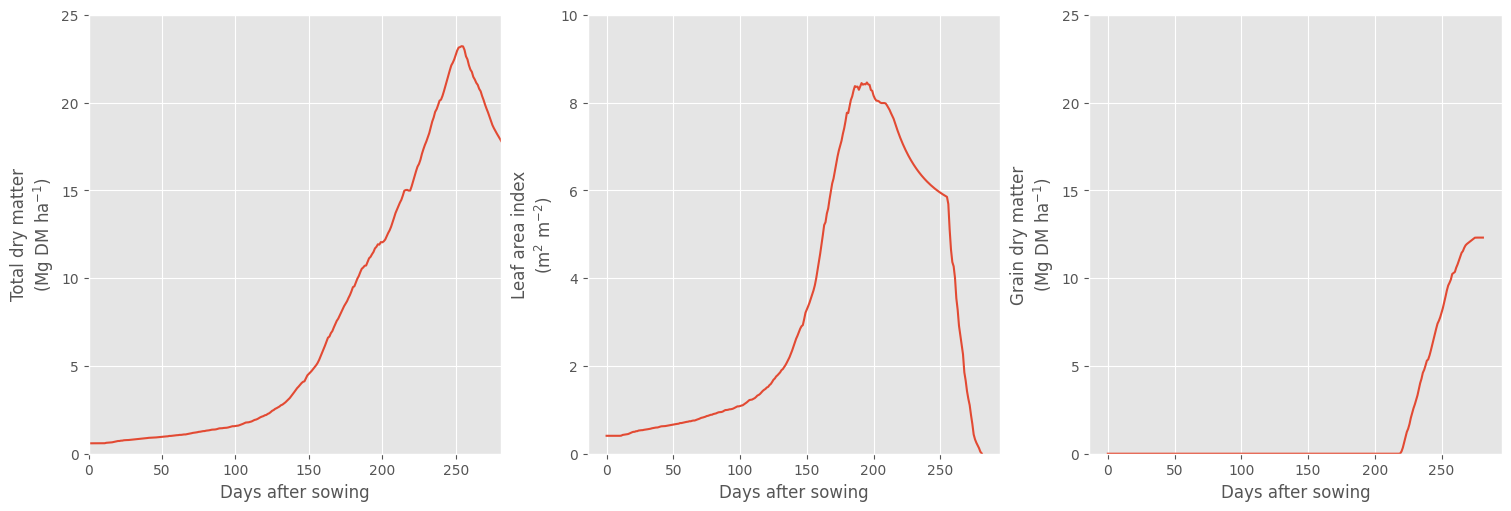

In [33]:
from w81_plotting import plot_w72_variables
import matplotlib.pyplot as plt
from datetime import datetime
df_output
fig_1 = plot_w72_variables(df_output)

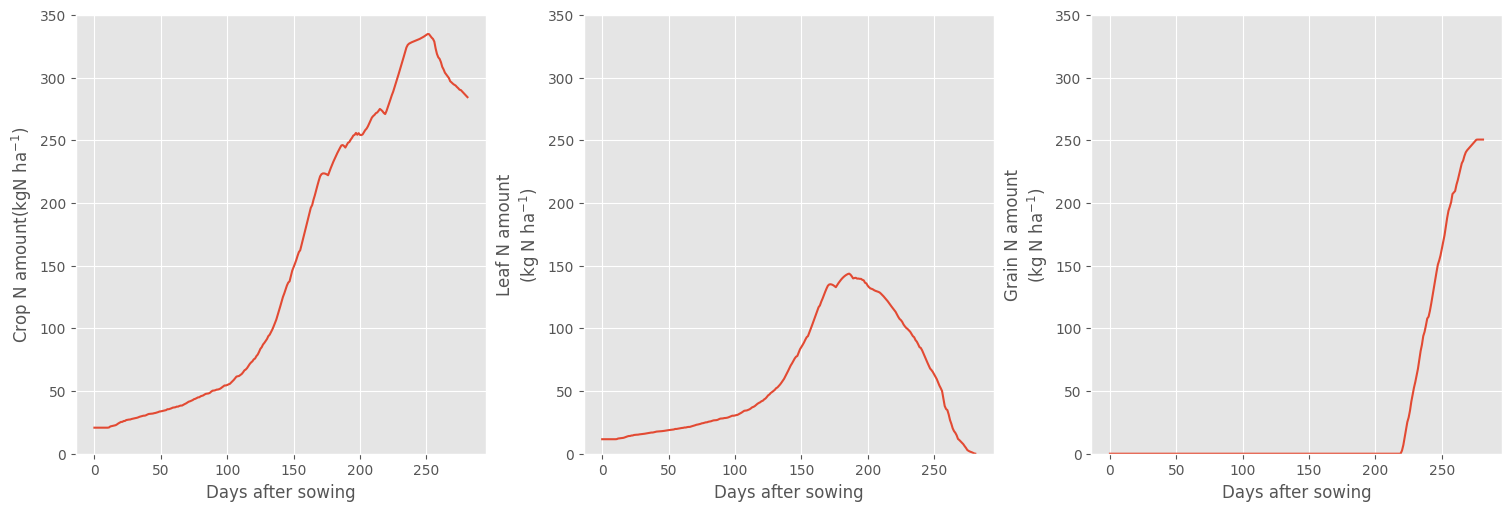

In [34]:
from w81_plotting import plot_w81_crop_variables

fig_2 = plot_w81_crop_variables(df_output)

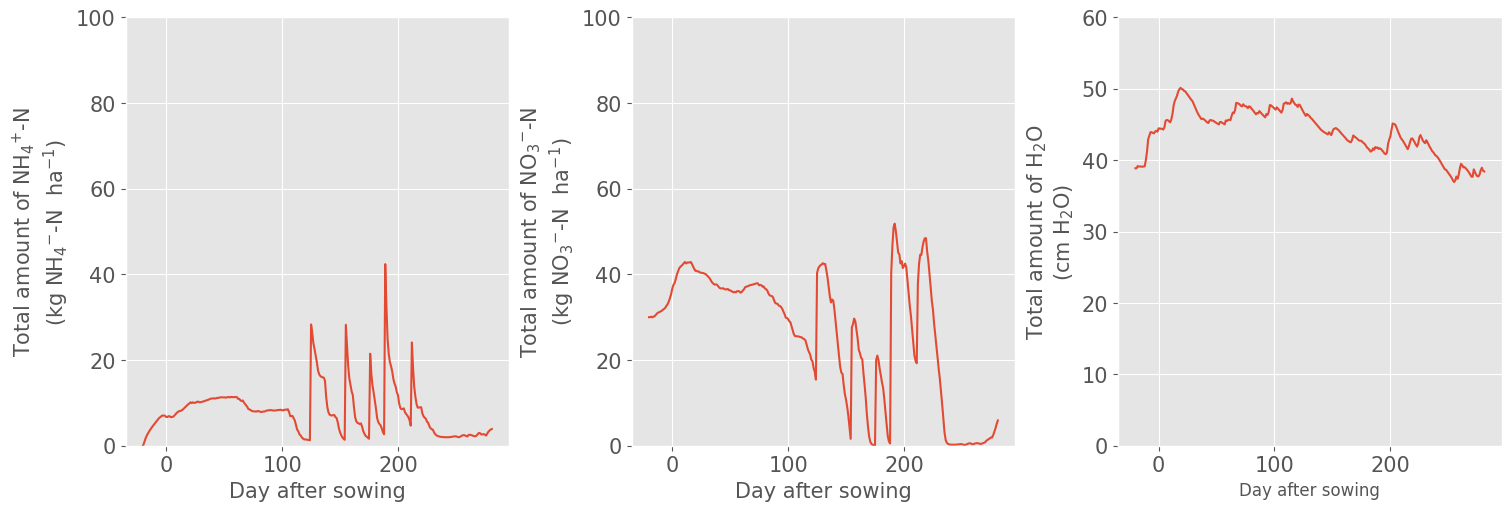

In [35]:
from w81_plotting import plot_w81_soil_totals

fig_3 = plot_w81_soil_totals(df_output, Thickness, nlayers)